In [1]:
!pip install -q keras-cv
!pip install -q tensorflow

In [2]:
import math
import random
import os
from textwrap import wrap

import keras_cv
import numpy as np
import tensorflow as tf
from keras_cv import layers as cv_layers
from keras_cv.models.stable_diffusion import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from tensorflow import keras
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd

stable_diffusion = keras_cv.models.StableDiffusion()

2023-05-16 02:28:39.290476: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-16 02:28:40.475489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 02:28:42.364004: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [3]:
def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

In [4]:
def assemble_image_dataset(urls):
    # Fetch all remote files
    files = [tf.io.read_file(url) for url in urls]

    files = [tf.io.read_file(image_path) for image_path in urls]
    images = [tf.io.decode_png(image, 3) for image in files]
    images = [tf.image.resize(image, (512, 512)) for image in images]

    # Resize images
    resize = keras.layers.Resizing(height=512, width=512, crop_to_aspect_ratio=True)
    images = [keras.utils.load_img(img) for img in files]
    images = [keras.utils.img_to_array(img) for img in images]
    images = np.array([resize(img) for img in images])

    # The StableDiffusion image encoder requires images to be normalized to the
    # [-1, 1] pixel value range
    images = images / 127.5 - 1

    # Create the tf.data.Dataset
    image_dataset = tf.data.Dataset.from_tensor_slices(images)

    # Shuffle and introduce random noise
    image_dataset = image_dataset.shuffle(50, reshuffle_each_iteration=True)
    image_dataset = image_dataset.map(
        cv_layers.RandomCropAndResize(
            target_size=(512, 512),
            crop_area_factor=(0.8, 1.0),
            aspect_ratio_factor=(1.0, 1.0),
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    image_dataset = image_dataset.map(
        cv_layers.RandomFlip(mode="horizontal"),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return image_dataset

In [5]:
MAX_PROMPT_LENGTH = 77
placeholder_token = "<new-yorker-token>"


def pad_embedding(embedding):
    return embedding + (
        [stable_diffusion.tokenizer.end_of_text] * (MAX_PROMPT_LENGTH - len(embedding))
    )


stable_diffusion.tokenizer.add_tokens(placeholder_token)


def assemble_text_dataset(prompts):
    prompts = [prompt.format(placeholder_token) for prompt in prompts]
    embeddings = [stable_diffusion.tokenizer.encode(prompt) for prompt in prompts]
    embeddings = [np.array(pad_embedding(embedding)) for embedding in embeddings]
    text_dataset = tf.data.Dataset.from_tensor_slices(embeddings)
    text_dataset = text_dataset.shuffle(100, reshuffle_each_iteration=True)
    return text_dataset

In [6]:
def assemble_dataset(urls, prompts):
    image_dataset = assemble_image_dataset(urls)
    text_dataset = assemble_text_dataset(prompts)
    # the image dataset is quite short, so we repeat it to match the length of the
    # text prompt dataset
    image_dataset = image_dataset.repeat()
    # we use the text prompt dataset to determine the length of the dataset.  Due to
    # the fact that there are relatively few prompts we repeat the dataset 5 times.
    # we have found that this anecdotally improves results.
    text_dataset = text_dataset.repeat(5)
    return tf.data.Dataset.zip((image_dataset, text_dataset))

In [7]:
dataset = load_dataset("jmhessel/newyorker_caption_contest", "matching")
train, validation, test = dataset["train"], dataset["validation"], dataset["test"]

Found cached dataset newyorker_caption_contest (/home/ugo1/.cache/huggingface/datasets/jmhessel___newyorker_caption_contest/matching/1.0.0/43749f7b7c0566b3b1bb518ee81866c0ae27f310ad1b3405918479d6eafcaabe)


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
data_path = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/ai2-jack-public/caption_contest_data_public/all_contest_images.zip",
    extract=True,
)
data_path = os.path.splitext(data_path)[0]

columns_to_remove = [
    "image", 
    "image_uncanny_description", 
    "entities", 
    "questions", 
    "n_tokens_label", 
    "instance_id"
]

data_frame = pd.DataFrame(train.select(train.unique("contest_number")).remove_columns(columns_to_remove))
data_frame["image_path"] = data_frame["contest_number"].apply(lambda x: os.path.join(data_path, str(x) + ".jpeg"))
data_frame["caption"] = data_frame["image_description"].apply(lambda x: x + " {}")
data_frame.head()

,contest_number,image_location,image_description,caption_choices,from_description,label,image_path,caption
0,742,an art gallery,A group of people are standing in an art museu...,[I'm surprised you can ghostwrite for him. I'v...,scene: an art gallery description: A group of ...,C,/home/ugo1/.keras/datasets/all_contest_images/...,A group of people are standing in an art museu...
1,115,a bar,A man in a hazmat suit is having a drink with ...,[Well the catcher is wearing a mask but everyo...,scene: a bar description: A man in a hazmat su...,D,/home/ugo1/.keras/datasets/all_contest_images/...,A man in a hazmat suit is having a drink with ...
2,474,an office,Two businessmen are passing a colleague. He ha...,"[This suit looked way better in the store., I ...",scene: an office description: Two businessmen ...,D,/home/ugo1/.keras/datasets/all_contest_images/...,Two businessmen are passing a colleague. He ha...
3,627,a ledge of a building,There are two people looking at a menu on a ba...,"[The board just voted to remove the net., Bob ...",scene: a ledge of a building description: Ther...,C,/home/ugo1/.keras/datasets/all_contest_images/...,There are two people looking at a menu on a ba...
4,528,an office room,A business meeting is going on. The boss is at...,[Maybe His Highness should make reservations n...,scene: an office room description: A business ...,E,/home/ugo1/.keras/datasets/all_contest_images/...,A business meeting is going on. The boss is at...


In [9]:
# The padding token and maximum prompt length are specific to the text encoder.
# If you're using a different text encoder be sure to change them accordingly.
PADDING_TOKEN = 49407
MAX_PROMPT_LENGTH = 77

# Load the tokenizer.
tokenizer = SimpleTokenizer()

#  Method to tokenize and pad the tokens.
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    return np.array(tokens)

# Drop rows whose caption length is greater than MAX_PROMPT_LENGTH
data_frame = data_frame[data_frame["caption"].apply(lambda x: len(process_text(x)) <= MAX_PROMPT_LENGTH)]

# Collate the tokenized captions into an array.
tokenized_texts = np.empty((len(data_frame), MAX_PROMPT_LENGTH))


all_captions = list(data_frame["caption"].values)
for i, caption in enumerate(all_captions):
    tokenized_texts[i] = process_text(caption)

In [10]:
RESOLUTION = 256
AUTO = tf.data.AUTOTUNE
POS_IDS = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)

augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.CenterCrop(RESOLUTION, RESOLUTION),
        keras_cv.layers.RandomFlip(),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)
text_encoder = TextEncoder(MAX_PROMPT_LENGTH)

def process_image(image_path, tokenized_text):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
    return image, tokenized_text


def apply_augmentation(image_batch, token_batch):
    return augmenter(image_batch), token_batch


def run_text_encoder(image_batch, token_batch):
    return (
        image_batch,
        token_batch,
        text_encoder([token_batch, POS_IDS], training=False),
    )


def prepare_dict(image_batch, token_batch, encoded_text_batch):
    return {
        "images": image_batch,
        "tokens": token_batch,
        "encoded_text": encoded_text_batch,
    }


def prepare_dataset(image_paths, tokenized_texts, batch_size=1):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, tokenized_texts))
    dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.map(process_image, num_parallel_calls=AUTO).batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=AUTO)
    dataset = dataset.map(run_text_encoder, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_dict, num_parallel_calls=AUTO)
    return dataset.prefetch(AUTO)


2023-05-16 02:28:53.312726: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44129 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:86:00.0, compute capability: 7.5


In [11]:
# Prepare the dataset.
training_dataset = prepare_dataset(
    np.array(data_frame["image_path"]), tokenized_texts, batch_size=4
)

# Take a sample batch and investigate.
sample_batch = next(iter(training_dataset))

for k in sample_batch:
    print(k, sample_batch[k].shape) 


2023-05-16 02:28:58.847593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip/loop_body/stateful_uniform/StatelessRandomUniformV2/pfor/while/random_flip/loop_body/stateful_uniform/shape' with dtype int64 and shape [0]
	 [[{{node random_flip/loop_body/stateful_uniform/StatelessRandomUniformV2/pfor/while/random_flip/loop_body/stateful_uniform/shape}}]]


2023-05-16 02:28:59.221661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sequential/random_flip/loop_body/stateful_uniform/StatelessRandomUniformV2/pfor/while/sequential/random_flip/loop_body/stateful_uniform/shape' with dtype int64 and shape [0]
	 [[{{node sequential/random_flip/loop_body/stateful_uniform/StatelessRandomUniformV2/pfor/while/sequential/random_flip/loop_body/stateful_uniform/shape}}]]
2023-05-16 02:29:00.952828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_99' with dtype resource
	 [[{{node Placeholder/_99}}]]
2023-05-16 02:29:00.957131: I tensorflow/core/common_runtime/executor.cc:11

images (4, 256, 256, 3)
tokens (4, 77)
encoded_text (4, 77, 768)


2023-05-16 02:29:04.582492: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): CANCELLED: RecvAsync is cancelled.
	 [[{{node unknown/_2}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2023-05-16 02:29:04.582976: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): CANCELLED: RecvAsync is cancelled.
	 [[{{node unknown/_2}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2023-05-16 02:29:04.583493: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): CANCELLED: RecvAsync is cancelled.
	 [[{{node text_encoder/clip_encoder_layer_8/clip_att

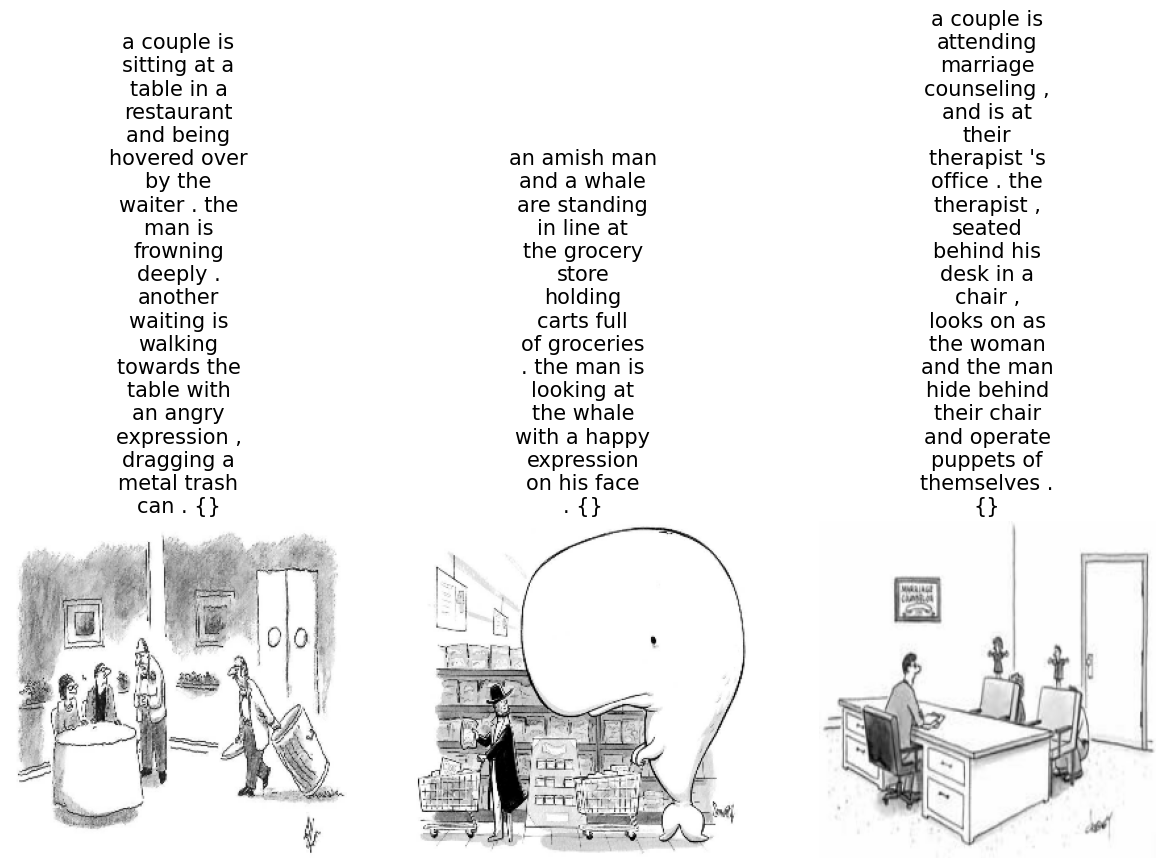

In [12]:
plt.figure(figsize=(20, 10))

for i in range(3):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow((sample_batch["images"][i] + 1) / 2)

    text = tokenizer.decode(sample_batch["tokens"][i].numpy().squeeze())
    text = text.replace("<|startoftext|>", "")
    text = text.replace("<|endoftext|>", "")
    text = "\n".join(wrap(text, 12))
    plt.title(text, fontsize=15)

    plt.axis("off")

In [13]:
def assemble_image_dataset(urls):
    # Fetch all remote files
    files = [tf.io.read_file(url) for url in urls]


    # Resize images
    files = [tf.io.read_file(image_path) for image_path in urls]
    images = [tf.io.decode_png(image, 3) for image in files]
    images = [tf.image.resize(image, (512, 512)) for image in images]
    images = np.array([image.numpy() for image in images])

    # The StableDiffusion image encoder requires images to be normalized to the
    # [-1, 1] pixel value range
    images = images / 127.5 - 1

    # Create the tf.data.Dataset
    image_dataset = tf.data.Dataset.from_tensor_slices(images)

    # Shuffle and introduce random noise
    image_dataset = image_dataset.shuffle(50, reshuffle_each_iteration=True)
    image_dataset = image_dataset.map(
        cv_layers.RandomCropAndResize(
            target_size=(512, 512),
            crop_area_factor=(0.8, 1.0),
            aspect_ratio_factor=(1.0, 1.0),
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    image_dataset = image_dataset.map(
        cv_layers.RandomFlip(mode="horizontal"),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return image_dataset

In [14]:
prompts = data_frame["image_description"].values
urls = data_frame["image_path"].values

train_ds = assemble_dataset(urls, prompts)
train_ds = train_ds.batch(1).shuffle(
    train_ds.cardinality(), reshuffle_each_iteration=True
)

In [15]:
tokenized_initializer = stable_diffusion.tokenizer.encode("new yorker")[1]
new_weights = stable_diffusion.text_encoder.layers[2].token_embedding(
    tf.constant(tokenized_initializer)
)

# Get len of .vocab instead of tokenizer
new_vocab_size = len(stable_diffusion.tokenizer.vocab)

# The embedding layer is the 2nd layer in the text encoder
old_token_weights = stable_diffusion.text_encoder.layers[
    2
].token_embedding.get_weights()
old_position_weights = stable_diffusion.text_encoder.layers[
    2
].position_embedding.get_weights()

old_token_weights = old_token_weights[0]
new_weights = np.expand_dims(new_weights, axis=0)
new_weights = np.concatenate([old_token_weights, new_weights], axis=0)


In [16]:
# Have to set download_weights False so we can init (otherwise tries to load weights)
new_encoder = keras_cv.models.stable_diffusion.TextEncoder(
    keras_cv.models.stable_diffusion.stable_diffusion.MAX_PROMPT_LENGTH,
    vocab_size=new_vocab_size,
    download_weights=False,
)
for index, layer in enumerate(stable_diffusion.text_encoder.layers):
    # Layer 2 is the embedding layer, so we omit it from our weight-copying
    if index == 2:
        continue
    new_encoder.layers[index].set_weights(layer.get_weights())


new_encoder.layers[2].token_embedding.set_weights([new_weights])
new_encoder.layers[2].position_embedding.set_weights(old_position_weights)

stable_diffusion._text_encoder = new_encoder
stable_diffusion._text_encoder.compile(jit_compile=True)

In [17]:

stable_diffusion.diffusion_model.trainable = False
stable_diffusion.decoder.trainable = False
stable_diffusion.text_encoder.trainable = True

stable_diffusion.text_encoder.layers[2].trainable = True


def traverse_layers(layer):
    if hasattr(layer, "layers"):
        for layer in layer.layers:
            yield layer
    if hasattr(layer, "token_embedding"):
        yield layer.token_embedding
    if hasattr(layer, "position_embedding"):
        yield layer.position_embedding


for layer in traverse_layers(stable_diffusion.text_encoder):
    if isinstance(layer, keras.layers.Embedding) or "clip_embedding" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

new_encoder.layers[2].position_embedding.trainable = False

In [18]:
all_models = [
    stable_diffusion.text_encoder,
    stable_diffusion.diffusion_model,
    stable_diffusion.decoder,
]
print([[w.shape for w in model.trainable_weights] for model in all_models])

[[TensorShape([49409, 768])], [], []]


In [19]:

# Remove the top layer from the encoder, which cuts off the variance and only returns
# the mean
training_image_encoder = keras.Model(
    stable_diffusion.image_encoder.input,
    stable_diffusion.image_encoder.layers[-2].output,
)


def sample_from_encoder_outputs(outputs):
    mean, logvar = tf.split(outputs, 2, axis=-1)
    logvar = tf.clip_by_value(logvar, -30.0, 20.0)
    std = tf.exp(0.5 * logvar)
    sample = tf.random.normal(tf.shape(mean))
    return mean + std * sample


def get_timestep_embedding(timestep, dim=320, max_period=10000):
    half = dim // 2
    freqs = tf.math.exp(
        -math.log(max_period) * tf.range(0, half, dtype=tf.float32) / half
    )
    args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
    embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
    return embedding


def get_position_ids():
    return tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)


In [20]:

class StableDiffusionFineTuner(keras.Model):
    def __init__(self, stable_diffusion, noise_scheduler, **kwargs):
        super().__init__(**kwargs)
        self.stable_diffusion = stable_diffusion
        self.noise_scheduler = noise_scheduler

    def train_step(self, data):
        images, embeddings = data

        with tf.GradientTape() as tape:
            # Sample from the predicted distribution for the training image
            latents = sample_from_encoder_outputs(training_image_encoder(images))
            # The latents must be downsampled to match the scale of the latents used
            # in the training of StableDiffusion.  This number is truly just a "magic"
            # constant that they chose when training the model.
            latents = latents * 0.18215

            # Produce random noise in the same shape as the latent sample
            noise = tf.random.normal(tf.shape(latents))
            batch_dim = tf.shape(latents)[0]

            # Pick a random timestep for each sample in the batch
            timesteps = tf.random.uniform(
                (batch_dim,),
                minval=0,
                maxval=noise_scheduler.train_timesteps,
                dtype=tf.int64,
            )

            # Add noise to the latents based on the timestep for each sample
            noisy_latents = self.noise_scheduler.add_noise(latents, noise, timesteps)

            # Encode the text in the training samples to use as hidden state in the
            # diffusion model
            encoder_hidden_state = self.stable_diffusion.text_encoder(
                [embeddings, get_position_ids()]
            )

            # Compute timestep embeddings for the randomly-selected timesteps for each
            # sample in the batch
            timestep_embeddings = tf.map_fn(
                fn=get_timestep_embedding,
                elems=timesteps,
                fn_output_signature=tf.float32,
            )

            # Call the diffusion model
            noise_pred = self.stable_diffusion.diffusion_model(
                [noisy_latents, timestep_embeddings, encoder_hidden_state]
            )

            # Compute the mean-squared error loss and reduce it.
            loss = self.compiled_loss(noise_pred, noise)
            loss = tf.reduce_mean(loss, axis=2)
            loss = tf.reduce_mean(loss, axis=1)
            loss = tf.reduce_mean(loss)

        # Load the trainable weights and compute the gradients for them
        trainable_weights = self.stable_diffusion.text_encoder.trainable_weights
        grads = tape.gradient(loss, trainable_weights)

        # Gradients are stored in indexed slices, so we have to find the index
        # of the slice(s) which contain the placeholder token.
        index_of_placeholder_token = tf.reshape(tf.where(grads[0].indices == 49408), ())
        condition = grads[0].indices == 49408
        condition = tf.expand_dims(condition, axis=-1)

        # Override the gradients, zeroing out the gradients for all slices that
        # aren't for the placeholder token, effectively freezing the weights for
        # all other tokens.
        grads[0] = tf.IndexedSlices(
            values=tf.where(condition, grads[0].values, 0),
            indices=grads[0].indices,
            dense_shape=grads[0].dense_shape,
        )

        self.optimizer.apply_gradients(zip(grads, trainable_weights))
        return {"loss": loss}


2023-05-16 02:29:55.009764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1,77]
	 [[{{node Placeholder/_1}}]]
2023-05-16 02:29:56.317264: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x23bcaec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-16 02:29:56.317290: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-05-16 02:29:56.504855: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-16 02:30:04.748387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2023-05-16 02:30:0

 1/50 [..............................] - ETA: 14:48

2023-05-16 02:30:26.429713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:26.948264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 2/50 [>.............................] - ETA: 50s  

2023-05-16 02:30:27.472209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:27.991182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 3/50 [>.............................] - ETA: 49s

2023-05-16 02:30:28.515858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:29.034153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 4/50 [=>............................] - ETA: 47s

2023-05-16 02:30:29.558651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:30.077658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 5/50 [==>...........................] - ETA: 46s

2023-05-16 02:30:30.601028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:31.121062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 6/50 [==>...........................] - ETA: 45s

2023-05-16 02:30:31.644807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:32.163339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 7/50 [===>..........................] - ETA: 44s

2023-05-16 02:30:32.685993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:33.204553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 8/50 [===>..........................] - ETA: 43s

2023-05-16 02:30:33.728754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:34.247462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 9/50 [====>.........................] - ETA: 42s

2023-05-16 02:30:34.771232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:35.290253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


10/50 [=====>........................] - ETA: 41s

2023-05-16 02:30:35.816722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:36.336219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


11/50 [=====>........................] - ETA: 40s

2023-05-16 02:30:36.862836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:37.382841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


12/50 [======>.......................] - ETA: 39s

2023-05-16 02:30:37.908348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:38.427658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


13/50 [======>.......................] - ETA: 38s

2023-05-16 02:30:38.952387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:39.471038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


14/50 [=======>......................] - ETA: 37s

2023-05-16 02:30:39.995030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:40.515436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


15/50 [========>.....................] - ETA: 36s

2023-05-16 02:30:41.039686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:41.557718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


16/50 [========>.....................] - ETA: 35s

2023-05-16 02:30:42.083673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:42.601833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


17/50 [=========>....................] - ETA: 34s

2023-05-16 02:30:43.127547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:43.647938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


18/50 [=========>....................] - ETA: 33s

2023-05-16 02:30:44.172559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:44.692088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


19/50 [==========>...................] - ETA: 32s

2023-05-16 02:30:45.216608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:45.735141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


20/50 [===========>..................] - ETA: 31s

2023-05-16 02:30:46.259295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:46.778875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


21/50 [===========>..................] - ETA: 30s

2023-05-16 02:30:47.302519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:47.821686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


22/50 [============>.................] - ETA: 29s

2023-05-16 02:30:48.348124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:48.866624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


23/50 [============>.................] - ETA: 28s

2023-05-16 02:30:49.391522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:49.912805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


24/50 [=============>................] - ETA: 27s

2023-05-16 02:30:50.438012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:50.957865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


25/50 [==============>...............] - ETA: 26s

2023-05-16 02:30:51.481900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:52.002353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


26/50 [==============>...............] - ETA: 25s

2023-05-16 02:30:52.527739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:53.046787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


27/50 [===============>..............] - ETA: 24s

2023-05-16 02:30:53.571375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:54.090635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


28/50 [===============>..............] - ETA: 22s

2023-05-16 02:30:54.615397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:55.134107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


29/50 [================>.............] - ETA: 21s

2023-05-16 02:30:55.659908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:56.181336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


30/50 [=================>............] - ETA: 20s

2023-05-16 02:30:56.709097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:57.230034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


31/50 [=================>............] - ETA: 19s

2023-05-16 02:30:57.756777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:58.277891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


32/50 [==================>...........] - ETA: 18s

2023-05-16 02:30:58.805413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:30:59.326177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


33/50 [==================>...........] - ETA: 17s

2023-05-16 02:30:59.851815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:31:00.373018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


34/50 [===================>..........] - ETA: 16s

2023-05-16 02:31:00.898608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:31:01.418521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


35/50 [====================>.........] - ETA: 15s

2023-05-16 02:31:01.945069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:31:02.466013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


36/50 [====================>.........] - ETA: 14s

2023-05-16 02:31:02.991483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:31:03.512315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


37/50 [=====================>........] - ETA: 13s

2023-05-16 02:31:04.039551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:31:04.560492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


38/50 [=====================>........] - ETA: 12s

2023-05-16 02:31:05.087228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:31:05.608043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


39/50 [======================>.......] - ETA: 11s

2023-05-16 02:31:06.134446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:31:06.655416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


40/50 [=======================>......] - ETA: 10s

2023-05-16 02:31:07.181990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:31:07.702786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


41/50 [=======================>......] - ETA: 9s 

2023-05-16 02:31:08.230724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:31:08.754548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


42/50 [========================>.....] - ETA: 8s

2023-05-16 02:31:09.280564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:31:09.801654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


43/50 [========================>.....] - ETA: 7s

2023-05-16 02:31:10.329302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:31:10.850517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


44/50 [=========================>....] - ETA: 6s

2023-05-16 02:31:11.376928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:31:11.899135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


45/50 [==========================>...] - ETA: 5s

2023-05-16 02:31:12.424836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:31:12.946527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


46/50 [==========================>...] - ETA: 4s

2023-05-16 02:31:13.472017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:31:13.991675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


47/50 [===========================>..] - ETA: 3s

2023-05-16 02:31:14.518917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:31:15.040282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


48/50 [===========================>..] - ETA: 2s

2023-05-16 02:31:15.568282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:31:16.089734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


49/50 [============================>.] - ETA: 1s

2023-05-16 02:31:16.616277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-16 02:31:17.138058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


50/50 [==============================] - 69s 1s/step


2023-05-16 02:31:17.663985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [3,64,64,4]
	 [[{{node Placeholder/_0}}]]


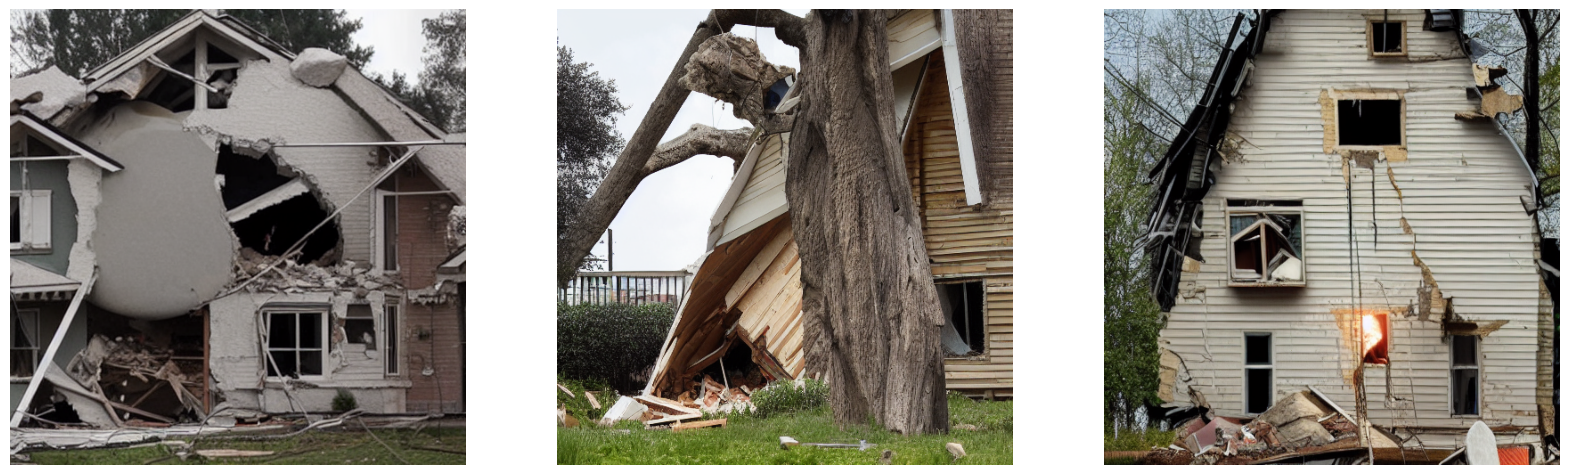

In [21]:
generated = stable_diffusion.text_to_image(
    f"a wrecking ball goes through a house. everyone inside is not disturbed by it. {placeholder_token}", seed=1337, batch_size=3
)
plot_images(generated)

In [22]:
noise_scheduler = NoiseScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    train_timesteps=1000,
)
trainer = StableDiffusionFineTuner(stable_diffusion, noise_scheduler, name="trainer")
EPOCHS = 50
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, decay_steps=train_ds.cardinality() * EPOCHS
)
optimizer = keras.optimizers.Adam(
    weight_decay=0.004, learning_rate=learning_rate, epsilon=1e-8, global_clipnorm=10
)

trainer.compile(
    optimizer=optimizer,
    # We are performing reduction manually in our train step, so none is required here.
    loss=keras.losses.MeanSquaredError(reduction="none"),
)

In [23]:

class GenerateImages(keras.callbacks.Callback):
    def __init__(
        self, stable_diffusion, prompt, steps=50, frequency=10, seed=None, **kwargs
    ):
        super().__init__(**kwargs)
        self.stable_diffusion = stable_diffusion
        self.prompt = prompt
        self.seed = seed
        self.frequency = frequency
        self.steps = steps

    def on_epoch_end(self, epoch, logs):
        if epoch % self.frequency == 0:
            images = self.stable_diffusion.text_to_image(
                self.prompt, batch_size=3, num_steps=self.steps, seed=self.seed
            )
            plot_images(
                images,
            )


cbs = [
    GenerateImages(
        stable_diffusion, prompt=f"a wrecking ball goes through a house. everyone inside is not disturbed by it. {placeholder_token}", seed=1337
    ),
    GenerateImages(
        stable_diffusion, prompt=f"a vampire is standing in the doorway of a woman's room . he is spreading his cape open facing the woman. the woman is laying in bed and looking over at the vampire in shock. {placeholder_token}", seed=1337
    ),
    GenerateImages(
        stable_diffusion,
        prompt=f"a caveman couple are waving from below up to a large building cave with another couple in it. the caveman building is very tall. {placeholder_token}",
        seed=1337,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "textual_inversion_stable_diffusion.h5",
        save_weights_only=True,
        monitor="loss",
        mode="min",
    ),
]

In [ ]:
trainer.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=cbs,
)

Epoch 1/50


2023-05-16 02:31:33.055691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int64 and shape [420,77]
	 [[{{node Placeholder/_14}}]]
2023-05-16 02:31:33.056070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [420,512,512,3]
	 [[{{node Placeholder/_0}}]]


 142/2100 [=>............................] - ETA: 23:22 - loss: 0.1810